In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
from scipy.interpolate import interp1d
from scipy.integrate import quad


# Second part of the WRE assignment (Tasks 5 to 8)

## Task 5
------------
Calculate the energy needed by the pump to provide the city with sufficient head
and the minimum level at the lake to get enough water to the city

#### Minimum flow

In [2]:
# load natural discharge
Q = np.loadtxt('Q_obs.txt')
t = np.arange(len(Q))

In [43]:
# get cumulative histogram
res = cumfreq(Q, numbins=500)
bins = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
freq = res.cumcount / res.cumcount[-1]

<IPython.core.display.Javascript object>


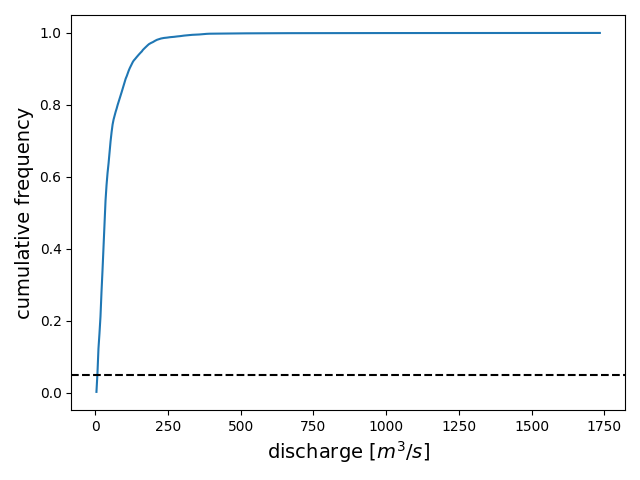

In [46]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(bins, freq)
ax.axhline(0.05, c='k', ls='--')

ax.set_xlabel(r'discharge $[m^3 / s]$', fontsize=14)
ax.set_ylabel(r'cumulative frequency', fontsize=14)

plt.tight_layout()

In [47]:
# we get graphically that
Q347 = 7.25 # [m^3 / s]

#### Volume rating curve

In [48]:
# load area rating curve
data = np.loadtxt('area_rating_curve.txt')
l = data[:, 0]
area = data[:, 1]

f_area = interp1d(l, area)
volume = [quad(f_area, 0, _l)[0] for _l in l] 
f_volume = interp1d(l, volume)
f_level = interp1d(volume, l)

<ipython-input-48-2933ff4a9f5d>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  volume = [quad(f_area, 0, _l)[0] for _l in l]
<ipython-input-48-2933ff4a9f5d>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  volume = [quad(f_area, 0, _l)[0] for _l in l]


<IPython.core.display.Javascript object>


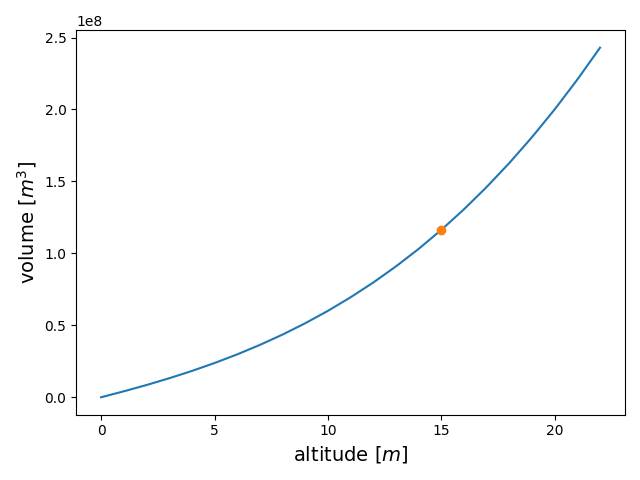

In [49]:
%matplotlib notebook

lmax = 15 # [m]
Vmax = f_volume(lmax)

x = np.linspace(l.min(), l.max(), 100)
V = f_volume(x)

fig, ax = plt.subplots()

ax.plot(x, V)
ax.plot([lmax], [Vmax], ls='None', marker='o')

ax.set_xlabel(r'altitude $[m]$', fontsize=14)
ax.set_ylabel(r'volume $[m^3]$', fontsize=14)

plt.tight_layout()

In [50]:
# list of parameters

# power plant
QT = 30 # [m^3 / s]
D = 3.6 # [m]
Lp = 1200 # [m]
ks = 0.5 # [mm]
eta = 0.75 # [-]
dz = 75 # [m]
lminHU = 9 # [m]

# river
Qlim = 100 # [m^3 / s]

# reservoir
Cqsl = 0.6 # [-]
Cqsp = 0.7 # [-]
Lspill = 140 # [m]
p = 19 # [m]

# water supply
Qcity = 1 # [m^3 / s]
etaP = 0.4 # [-]
etacrop = 0.8 # [-]
Acrop = 5 # [km^2]

In [71]:
def reservoir(Q, ET, P, l0, dt=3600, imax=None):

    data = {
        "volume": [float(f_volume(l0))],
        "level": [l0],
    }
    
    nsteps = len(Q)
    pp = False
    for i in range(nsteps):

        V = data["volume"][-1]
        l = data["level"][-1]

        # power plant supply
        if i % 24 == 8:
            if V >= Vmax:
                pp = True
            else:
                pp = False
        if i % 24 == 21:
            pp = False
            
        
        if pp:
            QHU = QT
        else:
            QHU = 0.

        # crops and city supply
        QI = (ET[i] - etaP * P[i]) / etacrop * (1e6 * Acrop)
        QSUP = QI + Qcity

        # gate oppening
        Qg = max(Q347, min((V + (Q[i] - QHU - QSUP) * dt -Vmax) / dt, Qlim))
        A = Qg / (Cqsl * (2 * 9.81 * l)**.5)

        # output discharge
        if l <= p:
            Qout = Qg
        else:
            Qout = Qg + Cqsp * Lspill * (2 * 9.81 * (l - p)**3)**.5

        Vnew = V + (Q[i] - Qout - QHU - QSUP) * dt
        lnew = float(f_level(Vnew))
        data["volume"].append(Vnew)
        data["level"].append(lnew)
        
        if imax is not None and i == imax:
            break
        
    return data

In [79]:
ET = np.zeros(len(Q))
P = np.zeros(len(Q))
l0 = 10

data = reservoir(Q, ET, P, l0, imax=1000)

<IPython.core.display.Javascript object>


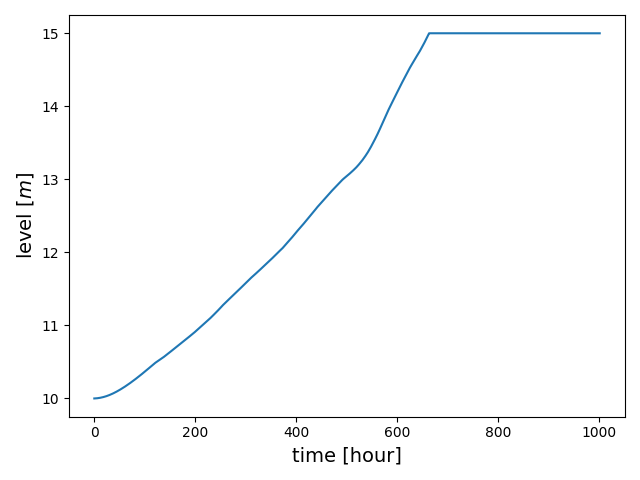

In [80]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(data['level'])

ax.set_xlabel(r'time [hour]', fontsize=14)
ax.set_ylabel(r'level $[m]$', fontsize=14)

plt.tight_layout()